In [ ]:
# Imports PIL module
import urllib.request
from PIL import Image
import os
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Colab Notebooks/Engine_TestData')
#image = Image.open('P001_test.jpg')
#image = plt.imread('list1.jpg')
#plt.imshow(image)

In [ ]:
## COMMENT IN in case you want to load the processed dataset from disk in case of error later
#Load the processed dataset from google drive
from transformers import DonutProcessor
from datasets import load_from_disk
from datasets import load_dataset
os.chdir('/content/drive/My Drive/Colab Notebooks/Engine_TestData/processed_dataset')
curr_path = os.getcwd()

processed_dataset = load_from_disk(curr_path)
os.chdir('/content/drive/My Drive/Colab Notebooks/Engine_TestData/processor')
curr_path = os.getcwd()
processor = DonutProcessor.from_pretrained(curr_path)

In [ ]:
processed_dataset = processed_dataset.train_test_split(test_size=0.8)
print(processed_dataset)

In [ ]:
import re
import transformers
from PIL import Image
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import random
import numpy as np
from transformers.image_transforms import to_pil_image

# hidde logs
transformers.logging.disable_default_handler()


# Load our model from Hugging Face
processor = DonutProcessor.from_pretrained("1992anubhav/donut-base-engine_logbook")
model = VisionEncoderDecoderModel.from_pretrained("1992anubhav/donut-base-engine_logbook")

os.chdir('/content/drive/My Drive/Colab Notebooks/Test_Data')
image = Image.open('N001_test.jpg')
#image = plt.imread('list1.jpg')
plt.imshow(image)
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

# Move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

#task_prompt = "<s_cord-v2>"
task_prompt = "<s>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

outputs = model.generate(pixel_values.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True,)


In [ ]:
sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
#sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(sequence)



In [ ]:
import re
import transformers
from PIL import Image
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import random
import numpy as np
from transformers.image_transforms import to_pil_image

# hidde logs
#transformers.logging.disable_default_handler()


# Load our model from Hugging Face
processor = DonutProcessor.from_pretrained("1992anubhav/donut-base-engine_logbook")
model = VisionEncoderDecoderModel.from_pretrained("1992anubhav/donut-base-engine_logbook")

test_sample = processed_dataset["test"][random.randint(1, 7)]
#print(pixel_values.shape)


def run_prediction(sample, model=model, processor=processor):
    # prepare inputs
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
        output_scores=True
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    # load reference target
    target = processor.token2json(test_sample["target_sequence"])
    return prediction, target

prediction, target = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")
pixel_values = np.squeeze(test_sample["pixel_values"])
#print(pixel_values)
pixel_values = (pixel_values + 1) / 2
#processor.feature_extractor.to_pil_image(pixel_values)
to_pil_image(pixel_values)

TEST METRICS- Confusion Matrix, Overall Accuracy 

In [105]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

processor = DonutProcessor.from_pretrained("1992anubhav/donut-base-engine_logbook")
model = VisionEncoderDecoderModel.from_pretrained("1992anubhav/donut-base-engine_logbook")


def run_prediction1(sample, model=model, processor=processor):
    # prepare inputs
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    pixel_values = torch.tensor(sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
        output_scores=True
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    # load reference target
    target = processor.token2json(sample["target_sequence"])
    return prediction, target



# define counter for samples
true_counter = 0
total_counter = 0
y_test = [0] * 100
y_pred = [0] * 100
pred = False

# iterate over dataset
for sample in tqdm(processed_dataset["test"]):
  prediction, target = run_prediction1(sample)
  for s in zip(prediction.values(), target.values()):
    print("S[0]:S[1]",s[0], s[1])
    if s[0] == s[1]:
      true_counter += 1
      y_pred[true_counter] = 1
      pred = True
    total_counter += 1
    y_test[total_counter] = 1




print(f"Accuracy: {(true_counter/total_counter)*100}%")


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:649: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
 12%|█▎        | 1/8 [00:02<00:14,  2.00s/it]

S[0]:S[1] JC890110 JC890110
S[0]:S[1] CA1312 CA1312
S[0]:S[1] 1200 1200
S[0]:S[1] K413956 KH13956
S[0]:S[1] 05/06/2005 05/06/2005
S[0]:S[1] Cessna 182 Cessna 182
S[0]:S[1] 6500 6500
S[0]:S[1] 4200 4200
S[0]:S[1] KH7619 KH7619
S[0]:S[1] N1165S N1165S


 25%|██▌       | 2/8 [00:03<00:10,  1.81s/it]

S[0]:S[1] 1200 1200
S[0]:S[1] TFE75801 TFE75801
S[0]:S[1] F854401G F854401G
S[0]:S[1] Safran Safran
S[0]:S[1] 11/05/2008 11/05/2008
S[0]:S[1] L-197 L-197
S[0]:S[1] N223CA N223CA


 38%|███▊      | 3/8 [00:05<00:08,  1.75s/it]

S[0]:S[1] JC11204118 JC1120418
S[0]:S[1] CA1312 CA1312
S[0]:S[1] 2000 2000
S[0]:S[1] RW76651MM RW76651MK
S[0]:S[1] 08/12/2008 08/12/2008
S[0]:S[1] Pilling 257 Viking 287
S[0]:S[1] 9191 9191
S[0]:S[1] 8000 8000
S[0]:S[1] HM6418 HM8418
S[0]:S[1] G7388M G7388M


 50%|█████     | 4/8 [00:06<00:06,  1.70s/it]

S[0]:S[1] JC42287634 JC42287634
S[0]:S[1] CA1312 CA1312
S[0]:S[1] 1800 1800
S[0]:S[1] LM191434 LM191434
S[0]:S[1] 01/08/2014 01/08/2034
S[0]:S[1] Cessna 206 Cessna 206
S[0]:S[1] 3400 3400
S[0]:S[1] 2400 2400
S[0]:S[1] FG1418 FG1418
S[0]:S[1] N589J N5391J


 62%|██████▎   | 5/8 [00:08<00:04,  1.64s/it]

S[0]:S[1] 1200 1200
S[0]:S[1] IO-36098 IO-36098
S[0]:S[1] JH998 JH998
S[0]:S[1] Lycoming Lycoming
S[0]:S[1] 10/05/2012 10/05/2012
S[0]:S[1] J31C J31C
S[0]:S[1] N98YZ N98YZ


 75%|███████▌  | 6/8 [00:10<00:03,  1.64s/it]

S[0]:S[1] JC996883 JC996883
S[0]:S[1] HL68835 H31312
S[0]:S[1] 02/03/2016 1100
S[0]:S[1] Pilatus PC-24 HL68835
S[0]:S[1] 11000 02/03/2016
S[0]:S[1] 5000 Pilatus PC-24
S[0]:S[1] PC7689 11000
S[0]:S[1] H3535H 5000


 88%|████████▊ | 7/8 [00:11<00:01,  1.60s/it]

S[0]:S[1] 1200 1200
S[0]:S[1] NL-382 NL-382
S[0]:S[1] JH688 JH688
S[0]:S[1] Lycoming Lycoming
S[0]:S[1] 20/08/2014 20/08/2014
S[0]:S[1] J82PN J82PN
S[0]:S[1] N101HL N101HL


100%|██████████| 8/8 [00:13<00:00,  1.66s/it]

S[0]:S[1] JC422012 JC42201212
S[0]:S[1] CA1312 CA1312
S[0]:S[1] 2000 2000
S[0]:S[1] HG57RE HG567RE
S[0]:S[1] 05/11/2012 05/11/2012
S[0]:S[1] Cessna 206 Cessna 206
S[0]:S[1] 3200 3200
S[0]:S[1] 2300 2300
S[0]:S[1] KG6418 KG6418
S[0]:S[1] FY388M FY388M
Accuracy: 76.81159420289855%


y_test [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y_pred [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Total parameters Extracted: 69
Correctly Predicted: 53

Confusion matrix

 [[31  0]
 [16 53]]


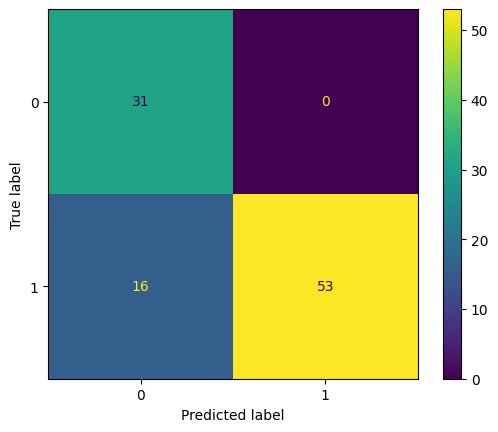

              precision    recall  f1-score   support

           0       0.66      1.00      0.79        31
           1       1.00      0.77      0.87        69

    accuracy                           0.84       100
   macro avg       0.83      0.88      0.83       100
weighted avg       0.89      0.84      0.85       100



In [106]:
#print(classification_report(target, prediction))
print("y_test", y_test)
print("y_pred", y_pred)
print("Total parameters Extracted:",total_counter)
print("Correctly Predicted:",true_counter)
cm = confusion_matrix(y_test, y_pred)
print('\nConfusion matrix\n\n', cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred))

In [ ]:
import torch
import re
from transformers import DonutProcessor, VisionEncoderDecoderModel

os.chdir('/content/drive/My Drive/Colab Notebooks/Dataset/img')
image = Image.open('E017.jpg')
#image = plt.imread('list1.jpg')
plt.imshow(image)
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)
#DOCVQA 
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
questions = ["what is the aircraft registration number?",
            "What is date of installationD?",
            "Who is the engine manufacturer?",
            "What is the engine model number?",
            "What is the blade design number?",
            "What is the hub serial number?",
            ]

task_prompt = "<s_docvqa><s_question>{user_input}</s_question><s_answer>"
for each in questions:
    question = each
    prompt = task_prompt.replace("{user_input}", question)
    decoder_input_ids = processor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]
    outputs = model.generate(pixel_values.to(device),
                                decoder_input_ids=decoder_input_ids.to(device),
                                max_length=model.decoder.config.max_position_embeddings,
                                early_stopping=True,
                                pad_token_id=processor.tokenizer.pad_token_id,
                                eos_token_id=processor.tokenizer.eos_token_id,
                                use_cache=True,
                                num_beams=1,
                                bad_words_ids=[[processor.tokenizer.unk_token_id]],
                                return_dict_in_generate=True,
                                output_scores=True)
    seq = processor.batch_decode(outputs.sequences)[0]
    print(processor.token2json(seq))